In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import numpy as np
import tensorflow as tf
import cv2
from keras.applications import vgg19
base_image_path = cv2.imread("/content/pexels-pixabay-53435.jpg")
style_reference_image_path = cv2.imread("/content/pexels-w-w-299285-889839.jpg")
result_prefix = "generated_image"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8
width, height, channels = base_image_path.shape
img_nrows = 400
img_ncols = int(width * img_nrows / height)
base_image_path = cv2.cvtColor(base_image_path, cv2.COLOR_BGR2RGB)

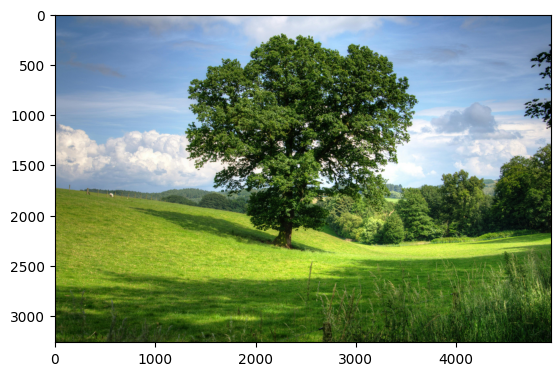

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(base_image_path)

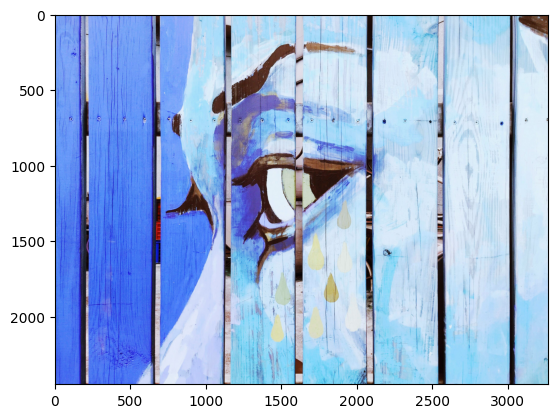

In [ ]:
plt.imshow(style_reference_image_path)

In [ ]:
def preprocess_image(image_path):

    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)

    img = np.expand_dims(img, axis=0)

    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):

    x = x.reshape((img_nrows, img_ncols, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [ ]:
def gram_matrix(x):

    x = tf.transpose(x, (2, 0, 1))

    features = tf.reshape(x, (tf.shape(x)[0], -1))

    gram = tf.matmul(features, tf.transpose(features))
    return gram



def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))



def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))



def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
style_layer_names =[
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):

    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)


    loss = tf.zeros(shape=())

    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features )

    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl


    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)


base_image = preprocess_image("/content/pexels-pixabay-53435.jpg")
style_reference_image = preprocess_image("/content/pexels-w-w-299285-889839.jpg")
combination_image = tf.Variable(preprocess_image("/content/pexels-pixabay-53435.jpg"))
iterations = 150
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 100: loss=16003.44


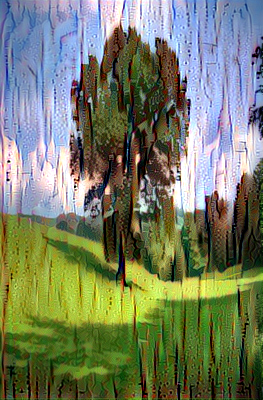

In [ ]:
from IPython.display import Image
Image(filename=result_prefix + "_at_iteration_100.png")